In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

#import os
#os.environ["LD_LIBRARY_PATH"]="/local/cuda-10.2/lib64"
#sys.path.append("/local/cuda-10.2/bin")


import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy
import pandas as pd

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *
from turing.pinns_experimental import TINN_masked, TINN_multi_nodes

2022-08-18 13:01:42.534650: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-08-18 13:01:53.502679: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-08-18 13:01:53.554990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-08-18 13:01:53.555030: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-08-18 13:01:53.557213: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-08-18 13:01:53.559404: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

In [2]:
df_params = pd.read_pickle("../../bacterialcolony_dataset/df_circuit2_variant5716gaussian_30000parametersets.pkl")

In [3]:
df_params.head()

,Va,Vb,Vc,Vd,Ve,Vf,ba,bb,bc,bd,...,kaa,kbd,kce,kda,keb,kee,kfe,mua,mulva,n
0,360.066204,69.840434,33.468912,283.316201,79.328098,35.847305,0.007714,0.009772,0.010261,0.008996,...,2.316063,2.874391,88.732068,9.363779,9.627162,0.275728,5.519184,4.664757,1.485684,2.0
1,271.955874,101.868916,28.546540,347.711607,84.727223,41.786928,0.008341,0.012020,0.013054,0.010064,...,4.883066,3.640181,99.577576,9.439324,7.552942,0.252092,4.607892,2.973656,1.423090,2.0
2,310.495835,79.551016,51.789526,197.624749,51.961358,40.627957,0.010750,0.015593,0.009346,0.013251,...,3.245317,4.944193,34.494922,13.954478,8.398245,0.299176,4.757444,4.151729,1.129469,2.0
3,368.363031,99.843451,51.223075,312.732434,89.436871,49.564425,0.008238,0.010022,0.007271,0.007357,...,2.941270,2.693431,89.807684,10.478264,7.656785,0.347844,6.552310,3.452419,1.213001,2.0
4,252.138904,90.823276,43.880020,293.190760,87.402367,59.800131,0.008995,0.008820,0.007773,0.011784,...,4.101435,3.625196,60.758534,9.479563,10.618988,0.174654,3.911595,4.190837,1.634196,2.0


In [4]:
import pickle

with open('../../bacterialcolony_dataset/2Dtimeseries_circuit2_variant5716gaussian_ca_fullcircuitID194_L10_J150_T120_N1200.pkl', 'rb') as f:
    ds_1 = pickle.load(f)
    
with open('../../bacterialcolony_dataset/caMask_seed1_pdivision0.5_L10_J150_T120_N1200.pkl', 'rb') as f:
    mask = pickle.load(f)


# Test two: Using mask

In [5]:
ID = 194
L = 10
data = np.array(ds_1)
nodes_n = data.shape[0]
node_names = ["A", "B", "C", "D", "E", "F"]
x_size = data.shape[1]
y_size = data.shape[2]
T = data.shape[3]
N = x_size*y_size

t_star = np.arange(0, T)

##########################
# select a subset of data
t_star = t_star[-2:]
T = len(t_star)
data = data[:, :, :, -2::]

model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': T*N}


dataset = create_dataset_multi_nodes_mask(data, mask, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = np.float32(dataset['obs_input'])
obs_Y = np.float32(dataset['obs_output'])
pde_X = np.float32(dataset['pde'])[dataset['pde_mask'] > 0, :]


In [6]:
layers = [3, 4*1024, 4*1024, 1024, 1024, 1024, 6]
#layers = [3, 1024, 512, 256, 128, 64, 6]
#layers = [3, 1024, 1024, 512, 256, 128, 6]
pinn = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_loss = Circuit2_variant5716(dtype=tf.float32, 
        D_A=df_params.d_A[ID],
        D_B = df_params.d_B[ID],
        b_A=df_params.ba[ID],
        b_B=df_params.bb[ID],
        b_C=df_params.bc[ID],
        b_D=df_params.bd[ID],
        b_E=df_params.be[ID],
        b_F=df_params.bf[ID],
        V_A=df_params.Va[ID],
        V_B=df_params.Vb[ID],
        V_C=df_params.Vc[ID],
        V_D=df_params.Vd[ID],
        V_E=df_params.Ve[ID],
        V_F=df_params.Vf[ID],
        k_AA=df_params.kaa[ID],
        k_BD=df_params.kbd[ID],
        k_CE=df_params.kce[ID],
        k_DA=df_params.kda[ID],
        k_EB=df_params.keb[ID],
        k_EE=df_params.kee[ID],
        k_FE=df_params.kfe[ID],
        mu_A=df_params.mua[ID],
        mulv_A=df_params.mulva[ID])

model = TINN_multi_nodes(pinn, 
                pde_loss, 
                nodes_n = nodes_n,
                node_names = node_names,
                optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                alpha = 0.9, 
                print_precision=".10f")

In [7]:
results = model.train(
        epochs = 5,
        batch_size = 32,
        X = obs_X,
        Y = obs_Y,
        print_interval=1,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)

model.optimizer.lr.assign(1e-4)

results2 = model.train(
        epochs = 50,
        batch_size = 32,
        X = obs_X,
        Y = obs_Y,
        print_interval=1,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)




Start of epoch 0


2022-08-18 13:02:20.794478: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-18 13:03:15.381116: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 1115.4282226562
total loss: 8821.4280512333, total regularisd loss (sum of batches): 12411242.8366699219
obs A loss: 2.8049412385, pde A loss: 824.1909373254
obs B loss: 4.5480088994, pde B loss: 63.2108406942
obs C loss: 4.1876417744, pde C loss: 10.6538120658
obs D loss: 6295.9365394115, pde D loss: 967.2861985770
obs E loss: 259.4024900696, pde E loss: 148.8583397358
obs F loss: 125.6928868848, pde F loss: 114.6554177568
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 357.85s

Start of epoch 1
Training observations acc over epoch: 1066.6234130859
total loss: 7745.3038669825, total regularisd loss (sum of batches): 10895476.5395507812
obs A loss: 1.90287235

Training observations acc over epoch: 275.2302551270
total loss: 3350.2553651929, total regularisd loss (sum of batches): 14305174.1210937500
obs A loss: 1.2583324315, pde A loss: 975.0948545337
obs B loss: 1.4702566379, pde B loss: 95.7652070448
obs C loss: 7.6340620132, pde C loss: 6.4697379499
obs D loss: 1341.4553011954, pde D loss: 352.8135273869
obs E loss: 189.6311505400, pde E loss: 77.1301431172
obs F loss: 109.9317910094, pde F loss: 191.6010022275
lambda obs A: 0.3878070116, lambda pde A: 0.8081098795
lambda obs B: 0.3883022070, lambda pde B: 0.4016098380
lambda obs C: 0.3934564590, lambda pde C: 0.3889142573
lambda obs D: 6.6060314178, lambda pde D: 0.4053215981
lambda obs E: 0.8408378959, lambda pde E: 0.3935369551
lambda obs F: 0.5499653220, lambda pde F: 0.4361064136

Time taken: 204.23s

Start of epoch 6
Training observations acc over epoch: 254.1998901367
total loss: 2880.1356642246, total regularisd loss (sum of batches): 12747431.3415527344
obs A loss: 1.7711624454, 

Training observations acc over epoch: 188.9360198975
total loss: 1919.5681031048, total regularisd loss (sum of batches): 10727342.4476318359
obs A loss: 11.0061083605, pde A loss: 351.0125484765
obs B loss: 1.1702518949, pde B loss: 83.4603193058
obs C loss: 3.7582525887, pde C loss: 10.5950171236
obs D loss: 981.9210654050, pde D loss: 275.3702428768
obs E loss: 112.5207504230, pde E loss: 54.7142670150
obs F loss: 23.2387202554, pde F loss: 10.8005576345
lambda obs A: 0.1670493484, lambda pde A: 0.4678420424
lambda obs B: 0.1392718554, lambda pde B: 0.2625079155
lambda obs C: 0.1605276018, lambda pde C: 0.1426749825
lambda obs D: 7.3838844299, lambda pde D: 0.2340108305
lambda obs E: 1.9796547890, lambda pde E: 0.1804224253
lambda obs F: 0.6627897024, lambda pde F: 0.2193641365

Time taken: 202.59s

Start of epoch 16
Training observations acc over epoch: 185.6109008789
total loss: 1858.8438687325, total regularisd loss (sum of batches): 10719531.4615478516
obs A loss: 10.4056501763,

Training observations acc over epoch: 181.0122528076
total loss: 1899.1482742429, total regularisd loss (sum of batches): 11583310.7867431641
obs A loss: 6.9442988506, pde A loss: 380.4701350182
obs B loss: 1.1469683805, pde B loss: 65.7199944463
obs C loss: 3.4139176634, pde C loss: 12.4403226790
obs D loss: 944.0015013255, pde D loss: 290.5069114808
obs E loss: 110.1146496711, pde E loss: 55.6196249411
obs F loss: 20.4530410338, pde F loss: 8.3169097430
lambda obs A: 0.0778069794, lambda pde A: 0.3668976426
lambda obs B: 0.0524837747, lambda pde B: 0.1217991710
lambda obs C: 0.0784735158, lambda pde C: 0.0577318706
lambda obs D: 8.2857570648, lambda pde D: 0.1830023080
lambda obs E: 2.2305159569, lambda pde E: 0.0915675312
lambda obs F: 0.3716258407, lambda pde F: 0.0823381469

Time taken: 205.54s

Start of epoch 26
Training observations acc over epoch: 177.3478546143
total loss: 1801.8037496209, total regularisd loss (sum of batches): 11395354.8991699219
obs A loss: 6.6382854048, pd

Training observations acc over epoch: 174.1242828369
total loss: 1909.8740261793, total regularisd loss (sum of batches): 11671162.6150512695
obs A loss: 5.2836842665, pde A loss: 447.5187972672
obs B loss: 1.1305142317, pde B loss: 55.0380661944
obs C loss: 3.0657240186, pde C loss: 16.1732266895
obs D loss: 905.5907539912, pde D loss: 266.8361902090
obs E loss: 108.8613892766, pde E loss: 70.3273085798
obs F loss: 20.8139099041, pde F loss: 9.2344591586
lambda obs A: 0.0380710587, lambda pde A: 0.3240076602
lambda obs B: 0.0221985485, lambda pde B: 0.0699514151
lambda obs C: 0.0451103859, lambda pde C: 0.0308745019
lambda obs D: 8.6886663437, lambda pde D: 0.1551603377
lambda obs E: 2.2590713501, lambda pde E: 0.0580152199
lambda obs F: 0.2758030891, lambda pde F: 0.0330703333

Time taken: 206.43s

Start of epoch 36
Training observations acc over epoch: 176.5012359619
total loss: 2015.1977979839, total regularisd loss (sum of batches): 11861633.4340820312
obs A loss: 4.9863758211, pd

Training observations acc over epoch: 171.8407897949
total loss: 1970.6867488623, total regularisd loss (sum of batches): 11636453.0028076172
obs A loss: 5.1982178228, pde A loss: 442.1523668617
obs B loss: 1.1091964481, pde B loss: 73.3585008984
obs C loss: 3.6512487959, pde C loss: 23.0394146182
obs D loss: 889.6915363446, pde D loss: 309.0159617234
obs E loss: 108.8461997425, pde E loss: 78.6329964320
obs F loss: 22.5490907151, pde F loss: 13.4420217333
lambda obs A: 0.0210426748, lambda pde A: 0.2852007449
lambda obs B: 0.0115574999, lambda pde B: 0.0594158843
lambda obs C: 0.0334363207, lambda pde C: 0.0262249466
lambda obs D: 8.8156061172, lambda pde D: 0.1387201995
lambda obs E: 2.2888476849, lambda pde E: 0.0485540219
lambda obs F: 0.2545694411, lambda pde F: 0.0168245099

Time taken: 198.77s

Start of epoch 46
Training observations acc over epoch: 171.6845855713
total loss: 1943.4257667959, total regularisd loss (sum of batches): 11641782.4843750000
obs A loss: 5.1140162147, p

In [14]:
model.optimizer.lr.assign(1e-5)

results3 = model.train(
        epochs = 50,
        batch_size = 32,
        X = obs_X,
        Y = obs_Y,
        print_interval=1,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)


Start of epoch 0
Training observations acc over epoch: 153.2421264648
total loss: 1367.0584269017, total regularisd loss (sum of batches): 10210525.8698120117
obs A loss: 4.6095159469, pde A loss: 178.6249828245
obs B loss: 0.9887218592, pde B loss: 28.6390747810
obs C loss: 3.7404293173, pde C loss: 12.4027893228
obs D loss: 787.1172613893, pde D loss: 167.2407142930
obs E loss: 105.8513893622, pde E loss: 53.4680436561
obs F loss: 17.1454303884, pde F loss: 7.2300744142
lambda obs A: 0.0172657035, lambda pde A: 0.2743100524
lambda obs B: 0.0095792878, lambda pde B: 0.0600474812
lambda obs C: 0.0321659446, lambda pde C: 0.0257617980
lambda obs D: 8.8091211319, lambda pde D: 0.1346191764
lambda obs E: 2.3200860023, lambda pde E: 0.0511037372
lambda obs F: 0.2517759204, lambda pde F: 0.0141647700

Time taken: 203.83s

Start of epoch 1
Training observations acc over epoch: 149.5442047119
total loss: 1285.2571145594, total regularisd loss (sum of batches): 9934584.3379516602
obs A loss: 

Training observations acc over epoch: 142.0729675293
total loss: 1309.0284442604, total regularisd loss (sum of batches): 9164409.8629150391
obs A loss: 5.3378710760, pde A loss: 128.5857320037
obs B loss: 0.9552970714, pde B loss: 27.4850784908
obs C loss: 2.9876729142, pde C loss: 12.5600004916
obs D loss: 723.1244609989, pde D loss: 234.4147529732
obs E loss: 107.2503585529, pde E loss: 47.2266014699
obs F loss: 12.7823787787, pde F loss: 6.3182348555
lambda obs A: 0.0174067579, lambda pde A: 0.1364539415
lambda obs B: 0.0079316953, lambda pde B: 0.0504404604
lambda obs C: 0.0356960595, lambda pde C: 0.0196532439
lambda obs D: 8.4715204239, lambda pde D: 0.1293382496
lambda obs E: 2.8660397530, lambda pde E: 0.0380847901
lambda obs F: 0.2183453143, lambda pde F: 0.0090891421

Time taken: 207.98s

Start of epoch 11
Training observations acc over epoch: 141.3075256348
total loss: 1315.4372970164, total regularisd loss (sum of batches): 9078031.3501586914
obs A loss: 5.2739898664, pde 

Training observations acc over epoch: 138.2197418213
total loss: 1299.6637811661, total regularisd loss (sum of batches): 8576940.8977050781
obs A loss: 5.3402305021, pde A loss: 139.5686265328
obs B loss: 0.9235867782, pde B loss: 22.4320970173
obs C loss: 2.5786479871, pde C loss: 12.3033060934
obs D loss: 701.5467075519, pde D loss: 240.7487538853
obs E loss: 107.3111383012, pde E loss: 47.5491208865
obs F loss: 11.6181207264, pde F loss: 7.7434459520
lambda obs A: 0.0186188687, lambda pde A: 0.0956507847
lambda obs B: 0.0076776133, lambda pde B: 0.0445152707
lambda obs C: 0.0356049463, lambda pde C: 0.0180428121
lambda obs D: 8.0813493729, lambda pde D: 0.1266440600
lambda obs E: 3.3505764008, lambda pde E: 0.0355634652
lambda obs F: 0.1774873734, lambda pde F: 0.0082689421

Time taken: 201.14s

Start of epoch 21
Training observations acc over epoch: 137.6398773193
total loss: 1294.1607143581, total regularisd loss (sum of batches): 8511758.4113159180
obs A loss: 5.2959699566, pde 

Training observations acc over epoch: 134.7961578369
total loss: 1265.5818851516, total regularisd loss (sum of batches): 8138780.5421752930
obs A loss: 5.1608332743, pde A loss: 130.7419844270
obs B loss: 0.8652080965, pde B loss: 21.4069611786
obs C loss: 2.4120450868, pde C loss: 12.9363741523
obs D loss: 682.0610488672, pde D loss: 238.7547140399
obs E loss: 106.8998041567, pde E loss: 44.0026278708
obs F loss: 11.3783642564, pde F loss: 8.9619199135
lambda obs A: 0.0185715873, lambda pde A: 0.0823946223
lambda obs B: 0.0076511097, lambda pde B: 0.0385057256
lambda obs C: 0.0339074209, lambda pde C: 0.0174092241
lambda obs D: 7.8368382454, lambda pde D: 0.1308671832
lambda obs E: 3.6259007454, lambda pde E: 0.0354633667
lambda obs F: 0.1614712626, lambda pde F: 0.0110191591

Time taken: 208.12s

Start of epoch 31
Training observations acc over epoch: 134.4399871826
total loss: 1253.4456259757, total regularisd loss (sum of batches): 8110544.1819458008
obs A loss: 5.1399020391, pde 

Training observations acc over epoch: 131.5655059814
total loss: 1232.0890002102, total regularisd loss (sum of batches): 7784247.8469238281
obs A loss: 5.0947799494, pde A loss: 131.4240321831
obs B loss: 0.8378068893, pde B loss: 20.6794158267
obs C loss: 2.3849716109, pde C loss: 12.9473819389
obs D loss: 664.0473577753, pde D loss: 225.6240729094
obs E loss: 106.0992857558, pde E loss: 43.1383864656
obs F loss: 10.9287074173, pde F loss: 8.8828011704
lambda obs A: 0.0189931635, lambda pde A: 0.0778103471
lambda obs B: 0.0077695502, lambda pde B: 0.0349112637
lambda obs C: 0.0344877169, lambda pde C: 0.0186512563
lambda obs D: 7.6373748779, lambda pde D: 0.1341454089
lambda obs E: 3.8275551796, lambda pde E: 0.0367627069
lambda obs F: 0.1581607908, lambda pde F: 0.0133782309

Time taken: 202.31s

Start of epoch 41
Training observations acc over epoch: 131.5247192383
total loss: 1223.2893675193, total regularisd loss (sum of batches): 7764127.6054077148
obs A loss: 5.1303239616, pde 

In [25]:
model.optimizer.lr.assign(1e-5)

results4 = model.train(
        epochs = 50,
        batch_size = 32,
        X = obs_X,
        Y = obs_Y,
        print_interval=1,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)


Start of epoch 0
Training observations acc over epoch: 134.9270324707
total loss: 1905.4083681107, total regularisd loss (sum of batches): 13176348.5550537109
obs A loss: 7.1447487957, pde A loss: 252.3158246726
obs B loss: 1.3750948933, pde B loss: 41.2193747927
obs C loss: 3.8278195885, pde C loss: 19.6521214026
obs D loss: 1060.7839521244, pde D loss: 274.4886206817
obs E loss: 155.3754638387, pde E loss: 58.1686316393
obs F loss: 18.1855767071, pde F loss: 12.8711418972
lambda obs A: 0.0171390679, lambda pde A: 0.1572987288
lambda obs B: 0.0078120884, lambda pde B: 0.0447346084
lambda obs C: 0.0343423188, lambda pde C: 0.0222041011
lambda obs D: 8.2977437973, lambda pde D: 0.1939550340
lambda obs E: 2.9747169018, lambda pde E: 0.0443938039
lambda obs F: 0.1893100739, lambda pde F: 0.0163497273

Time taken: 204.52s

Start of epoch 1
Training observations acc over epoch: 126.6776657104
total loss: 1082.6975272819, total regularisd loss (sum of batches): 7977329.3626708984
obs A loss

Training observations acc over epoch: 122.2691116333
total loss: 1054.5286203288, total regularisd loss (sum of batches): 7476042.9395751953
obs A loss: 4.9108380941, pde A loss: 101.4182415875
obs B loss: 0.7389843051, pde B loss: 16.8274835609
obs C loss: 2.2521582670, pde C loss: 10.8284560623
obs D loss: 616.0016185790, pde D loss: 153.1870621953
obs E loss: 100.7927752453, pde E loss: 32.0546874946
obs F loss: 8.9183200329, pde F loss: 6.5979963441
lambda obs A: 0.0195464958, lambda pde A: 0.1047987491
lambda obs B: 0.0080485111, lambda pde B: 0.0408708490
lambda obs C: 0.0399355553, lambda pde C: 0.0219340995
lambda obs D: 7.9892406464, lambda pde D: 0.1488962173
lambda obs E: 3.4184429646, lambda pde E: 0.0365387797
lambda obs F: 0.1574375778, lambda pde F: 0.0143098067

Time taken: 199.08s

Start of epoch 11
Training observations acc over epoch: 122.3592910767
total loss: 1056.3941974342, total regularisd loss (sum of batches): 7465630.0398559570
obs A loss: 4.8433746353, pde A

Training observations acc over epoch: 120.4775009155
total loss: 1055.8531339616, total regularisd loss (sum of batches): 7223634.3523559570
obs A loss: 4.9319895550, pde A loss: 101.1878422890
obs B loss: 0.7079575706, pde B loss: 15.9793694981
obs C loss: 2.0789283704, pde C loss: 10.3497529248
obs D loss: 607.1211045198, pde D loss: 166.3719700533
obs E loss: 99.1755106188, pde E loss: 32.3378081238
obs F loss: 8.8493536393, pde F loss: 6.7615463726
lambda obs A: 0.0218274351, lambda pde A: 0.0872009024
lambda obs B: 0.0080383047, lambda pde B: 0.0374542437
lambda obs C: 0.0434713587, lambda pde C: 0.0204778984
lambda obs D: 7.8074660301, lambda pde D: 0.1473120004
lambda obs E: 3.6252317429, lambda pde E: 0.0351436064
lambda obs F: 0.1520871669, lambda pde F: 0.0142891025

Time taken: 204.10s

Start of epoch 21
Training observations acc over epoch: 119.9477539062
total loss: 1059.4881473631, total regularisd loss (sum of batches): 7191997.8131103516
obs A loss: 4.9435851203, pde A 

Training observations acc over epoch: 118.2891921997
total loss: 1040.9567613900, total regularisd loss (sum of batches): 7066658.2565917969
obs A loss: 4.9236896076, pde A loss: 102.2248330303
obs B loss: 0.6815219429, pde B loss: 16.1530483902
obs C loss: 1.9917025824, pde C loss: 10.0460065409
obs D loss: 595.4194027521, pde D loss: 163.4964558692
obs E loss: 98.1429945785, pde E loss: 32.5479155171
obs F loss: 8.5756276743, pde F loss: 6.7535618384
lambda obs A: 0.0236250423, lambda pde A: 0.0838151127
lambda obs B: 0.0079718698, lambda pde B: 0.0377091654
lambda obs C: 0.0454058014, lambda pde C: 0.0191239696
lambda obs D: 7.7784914970, lambda pde D: 0.1530392319
lambda obs E: 3.6475286484, lambda pde E: 0.0354417115
lambda obs F: 0.1532854140, lambda pde F: 0.0145627465

Time taken: 204.51s

Start of epoch 31
Training observations acc over epoch: 118.1708908081
total loss: 1043.3565594181, total regularisd loss (sum of batches): 7063634.5510864258
obs A loss: 4.9726733022, pde A 

Training observations acc over epoch: 116.9563980103
total loss: 1041.4090952836, total regularisd loss (sum of batches): 7038272.1677856445
obs A loss: 4.9811075305, pde A loss: 100.7386799399
obs B loss: 0.6616961424, pde B loss: 15.4589145307
obs C loss: 1.9317272888, pde C loss: 9.5662655887
obs D loss: 589.2089562928, pde D loss: 174.4811195051
obs E loss: 96.4209298790, pde E loss: 32.9374477689
obs F loss: 8.5339978500, pde F loss: 6.4882513678
lambda obs A: 0.0256683771, lambda pde A: 0.0854945630
lambda obs B: 0.0079874247, lambda pde B: 0.0388038903
lambda obs C: 0.0472202152, lambda pde C: 0.0183076262
lambda obs D: 7.8559494019, lambda pde D: 0.1597440988
lambda obs E: 3.5526261330, lambda pde E: 0.0375346951
lambda obs F: 0.1556693912, lambda pde F: 0.0149939517

Time taken: 205.80s

Start of epoch 41
Training observations acc over epoch: 116.4631881714
total loss: 1029.5494368374, total regularisd loss (sum of batches): 7015631.4711914062
obs A loss: 4.9314914739, pde A l

In [26]:
results5 = model.train(
        epochs = 100,
        batch_size = 32,
        X = obs_X,
        Y = obs_Y,
        print_interval=1,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)


Start of epoch 0
Training observations acc over epoch: 115.3210449219
total loss: 1025.4284540713, total regularisd loss (sum of batches): 6985312.2314453125
obs A loss: 4.9153311281, pde A loss: 100.3025164800
obs B loss: 0.6399838756, pde B loss: 15.2670546200
obs C loss: 1.8877083957, pde C loss: 9.6513356318
obs D loss: 580.4746993147, pde D loss: 168.3277151932
obs E loss: 95.6533153816, pde E loss: 33.4336341121
obs F loss: 8.3552745916, pde F loss: 6.5198850436
lambda obs A: 0.0268728510, lambda pde A: 0.0880190432
lambda obs B: 0.0079364730, lambda pde B: 0.0396585241
lambda obs C: 0.0480748005, lambda pde C: 0.0185694955
lambda obs D: 7.9094457626, lambda pde D: 0.1693432033
lambda obs E: 3.4786229134, lambda pde E: 0.0400907248
lambda obs F: 0.1579067111, lambda pde F: 0.0154595152

Time taken: 204.47s

Start of epoch 1
Training observations acc over epoch: 115.1016998291
total loss: 1015.4006778151, total regularisd loss (sum of batches): 6970838.8465881348
obs A loss: 4.89

Training observations acc over epoch: 113.7251663208
total loss: 996.0136191547, total regularisd loss (sum of batches): 6962693.4276123047
obs A loss: 4.8738141555, pde A loss: 95.6452052807
obs B loss: 0.6269261076, pde B loss: 14.4668555240
obs C loss: 1.8652638651, pde C loss: 9.3106710968
obs D loss: 572.7316410802, pde D loss: 156.1999938220
obs E loss: 94.0543592023, pde E loss: 31.6332291206
obs F loss: 8.1992156352, pde F loss: 6.4064467085
lambda obs A: 0.0280561447, lambda pde A: 0.0903708115
lambda obs B: 0.0079740919, lambda pde B: 0.0402387790
lambda obs C: 0.0488302298, lambda pde C: 0.0191168878
lambda obs D: 8.0113754272, lambda pde D: 0.1726290733
lambda obs E: 3.3651633263, lambda pde E: 0.0416616723
lambda obs F: 0.1582955718, lambda pde F: 0.0162878800

Time taken: 205.42s

Start of epoch 11
Training observations acc over epoch: 113.6780548096
total loss: 1004.4943275601, total regularisd loss (sum of batches): 6960987.7345581055
obs A loss: 4.8502796546, pde A los

Training observations acc over epoch: 112.4617919922
total loss: 985.3247949183, total regularisd loss (sum of batches): 6918806.2363891602
obs A loss: 4.8692992494, pde A loss: 94.8338401364
obs B loss: 0.6247450095, pde B loss: 14.5566577354
obs C loss: 1.8400516913, pde C loss: 9.3964014362
obs D loss: 566.6035676748, pde D loss: 153.4044140563
obs E loss: 92.8223994561, pde E loss: 31.9150387116
obs F loss: 8.0102745465, pde F loss: 6.4481054371
lambda obs A: 0.0292603206, lambda pde A: 0.0911803916
lambda obs B: 0.0080624288, lambda pde B: 0.0410614870
lambda obs C: 0.0489356183, lambda pde C: 0.0201958437
lambda obs D: 8.0820837021, lambda pde D: 0.1799621880
lambda obs E: 3.2836332321, lambda pde E: 0.0431676507
lambda obs F: 0.1555554420, lambda pde F: 0.0169006418

Time taken: 203.01s

Start of epoch 21
Training observations acc over epoch: 112.5283355713
total loss: 994.0514344126, total regularisd loss (sum of batches): 6937836.8148803711
obs A loss: 4.8425709617, pde A loss

Training observations acc over epoch: 111.4696426392
total loss: 990.7670108229, total regularisd loss (sum of batches): 6937184.7790222168
obs A loss: 4.8328910386, pde A loss: 98.4392347485
obs B loss: 0.6160419758, pde B loss: 14.3914963576
obs C loss: 1.8438565146, pde C loss: 9.8453422566
obs D loss: 562.0958018843, pde D loss: 159.9843916749
obs E loss: 91.5360649119, pde E loss: 32.7928972852
obs F loss: 7.8932310007, pde F loss: 6.4957617170
lambda obs A: 0.0305040106, lambda pde A: 0.0923018903
lambda obs B: 0.0081924722, lambda pde B: 0.0418400317
lambda obs C: 0.0495079756, lambda pde C: 0.0219535995
lambda obs D: 8.1760416031, lambda pde D: 0.1861479729
lambda obs E: 3.1766569614, lambda pde E: 0.0450120345
lambda obs F: 0.1544093341, lambda pde F: 0.0174304210

Time taken: 202.16s

Start of epoch 31
Training observations acc over epoch: 111.1106414795
total loss: 986.7984199375, total regularisd loss (sum of batches): 6910563.7629699707
obs A loss: 4.7963303691, pde A loss

Training observations acc over epoch: 109.8725967407
total loss: 972.6709417105, total regularisd loss (sum of batches): 6893541.8899230957
obs A loss: 4.7734465564, pde A loss: 94.6756626489
obs B loss: 0.6018813941, pde B loss: 13.8260400586
obs C loss: 1.8303727457, pde C loss: 9.7145472894
obs D loss: 553.8659102544, pde D loss: 156.0455411974
obs E loss: 90.4001810630, pde E loss: 32.9306156079
obs F loss: 7.7635040851, pde F loss: 6.2432395212
lambda obs A: 0.0316381902, lambda pde A: 0.0942489132
lambda obs B: 0.0083181988, lambda pde B: 0.0421137884
lambda obs C: 0.0499309525, lambda pde C: 0.0237827878
lambda obs D: 8.2740154266, lambda pde D: 0.1964782178
lambda obs E: 3.0604729652, lambda pde E: 0.0469680727
lambda obs F: 0.1540909857, lambda pde F: 0.0179402772

Time taken: 202.04s

Start of epoch 41
Training observations acc over epoch: 109.5863342285
total loss: 972.7990375906, total regularisd loss (sum of batches): 6876258.7871704102
obs A loss: 4.8144727059, pde A loss

Training observations acc over epoch: 108.6486358643
total loss: 962.1704472154, total regularisd loss (sum of batches): 6852457.2168273926
obs A loss: 4.7852080944, pde A loss: 94.8095331108
obs B loss: 0.5960071388, pde B loss: 13.8731708425
obs C loss: 1.8365170785, pde C loss: 9.9102512925
obs D loss: 547.3514520824, pde D loss: 151.8391348151
obs E loss: 89.5823822478, pde E loss: 33.7987283161
obs F loss: 7.7406514573, pde F loss: 6.0474086695
lambda obs A: 0.0327435173, lambda pde A: 0.0955686197
lambda obs B: 0.0083604744, lambda pde B: 0.0432620272
lambda obs C: 0.0506089292, lambda pde C: 0.0258798189
lambda obs D: 8.3250331879, lambda pde D: 0.2047919035
lambda obs E: 2.9898977280, lambda pde E: 0.0491113290
lambda obs F: 0.1564350426, lambda pde F: 0.0183059908

Time taken: 207.82s

Start of epoch 51
Training observations acc over epoch: 108.2775573730
total loss: 964.4721510708, total regularisd loss (sum of batches): 6831315.0882568359
obs A loss: 4.7507678630, pde A loss

Training observations acc over epoch: 107.2592010498
total loss: 965.2137004286, total regularisd loss (sum of batches): 6811682.3098449707
obs A loss: 4.7150400628, pde A loss: 94.3559342097
obs B loss: 0.5872509846, pde B loss: 13.8094799393
obs C loss: 1.8521838244, pde C loss: 9.7637899761
obs D loss: 540.7563251741, pde D loss: 163.3519402063
obs E loss: 88.0746425907, pde E loss: 34.1693289871
obs F loss: 7.5692579673, pde F loss: 6.2085260559
lambda obs A: 0.0336536914, lambda pde A: 0.0968726724
lambda obs B: 0.0084390948, lambda pde B: 0.0439780131
lambda obs C: 0.0517406724, lambda pde C: 0.0269725695
lambda obs D: 8.3969812393, lambda pde D: 0.2170947790
lambda obs E: 2.8977339268, lambda pde E: 0.0506224334
lambda obs F: 0.1571491063, lambda pde F: 0.0187622439

Time taken: 204.61s

Start of epoch 61
Training observations acc over epoch: 107.1721343994
total loss: 957.7383996397, total regularisd loss (sum of batches): 6810077.4744567871
obs A loss: 4.7572257902, pde A loss

Training observations acc over epoch: 105.6932907104
total loss: 947.2002199087, total regularisd loss (sum of batches): 6741743.9484710693
obs A loss: 4.6997432136, pde A loss: 94.4339487753
obs B loss: 0.5734632703, pde B loss: 13.7893939095
obs C loss: 1.8355747339, pde C loss: 9.4885748113
obs D loss: 532.4850967138, pde D loss: 155.7727638995
obs E loss: 87.0963890431, pde E loss: 33.3599734580
obs F loss: 7.4696088838, pde F loss: 6.1956901508
lambda obs A: 0.0346569084, lambda pde A: 0.1000982225
lambda obs B: 0.0084203137, lambda pde B: 0.0463449471
lambda obs C: 0.0526985042, lambda pde C: 0.0276928563
lambda obs D: 8.4502267838, lambda pde D: 0.2307521105
lambda obs E: 2.8178148270, lambda pde E: 0.0521673597
lambda obs F: 0.1594079733, lambda pde F: 0.0197200924

Time taken: 207.66s

Start of epoch 71
Training observations acc over epoch: 105.8018569946
total loss: 950.8791340292, total regularisd loss (sum of batches): 6760204.6690673828
obs A loss: 4.7350098892, pde A loss

Training observations acc over epoch: 104.6527328491
total loss: 941.1230972558, total regularisd loss (sum of batches): 6700520.3684082031
obs A loss: 4.6880305168, pde A loss: 95.5274041868
obs B loss: 0.5610752060, pde B loss: 13.8968268936
obs C loss: 1.8211906939, pde C loss: 9.4450149853
obs D loss: 527.9054936618, pde D loss: 154.2358554872
obs E loss: 85.6125442153, pde E loss: 33.8463061119
obs F loss: 7.3274850700, pde F loss: 6.2558686229
lambda obs A: 0.0355088748, lambda pde A: 0.1040178388
lambda obs B: 0.0083736824, lambda pde B: 0.0477447584
lambda obs C: 0.0538870506, lambda pde C: 0.0284174774
lambda obs D: 8.4710235596, lambda pde D: 0.2426489890
lambda obs E: 2.7738440037, lambda pde E: 0.0543268770
lambda obs F: 0.1595965326, lambda pde F: 0.0206110384

Time taken: 205.78s

Start of epoch 81
Training observations acc over epoch: 104.0890197754
total loss: 938.9697632045, total regularisd loss (sum of batches): 6659815.9848022461
obs A loss: 4.6622112099, pde A loss

Training observations acc over epoch: 102.5760650635
total loss: 933.5605568998, total regularisd loss (sum of batches): 6575187.0863342285
obs A loss: 4.6649865870, pde A loss: 94.4375645425
obs B loss: 0.5480434789, pde B loss: 14.1807089177
obs C loss: 1.8127020491, pde C loss: 9.4786158967
obs D loss: 516.3957436625, pde D loss: 158.8892629160
obs E loss: 84.6915313080, pde E loss: 34.7774278870
obs F loss: 7.3435631893, pde F loss: 6.3404071400
lambda obs A: 0.0364755392, lambda pde A: 0.1058184505
lambda obs B: 0.0083340378, lambda pde B: 0.0502597578
lambda obs C: 0.0553370751, lambda pde C: 0.0288397260
lambda obs D: 8.5070476532, lambda pde D: 0.2587969005
lambda obs E: 2.7082054615, lambda pde E: 0.0577504970
lambda obs F: 0.1613371968, lambda pde F: 0.0217981283

Time taken: 201.64s

Start of epoch 91
Training observations acc over epoch: 103.2235107422
total loss: 937.7670167387, total regularisd loss (sum of batches): 6629852.6045227051
obs A loss: 4.6870649061, pde A loss

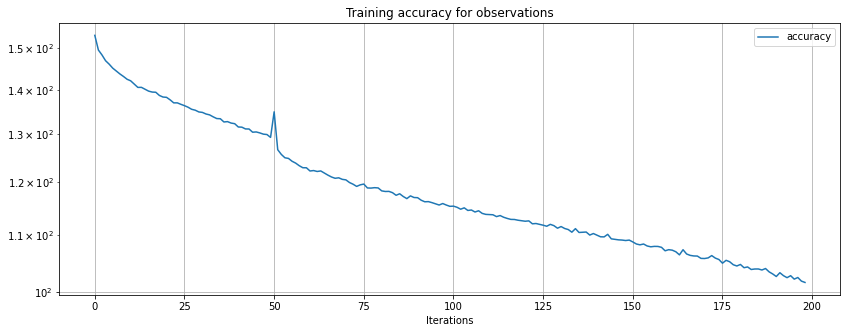

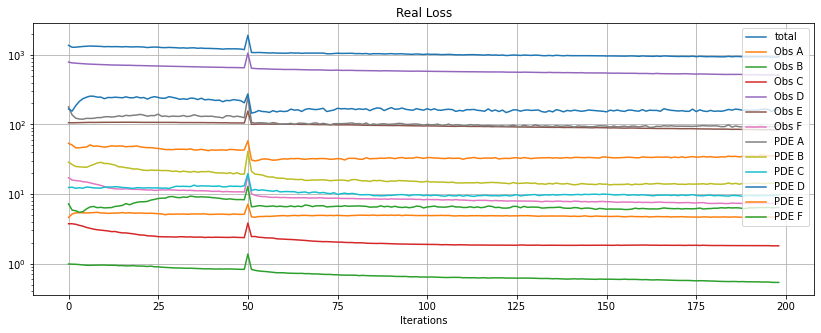

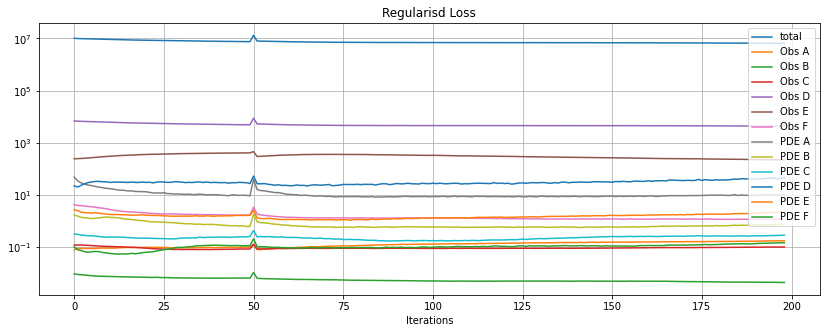

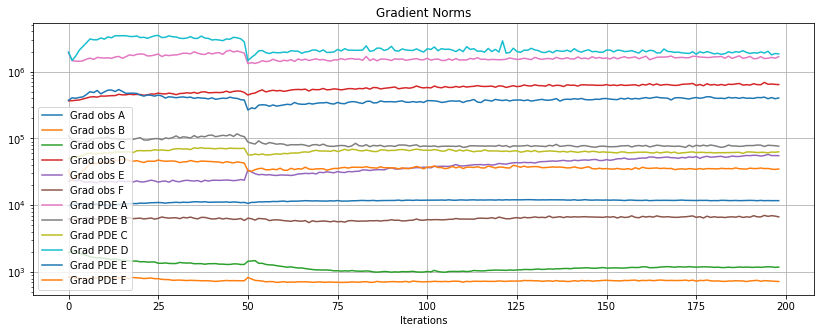

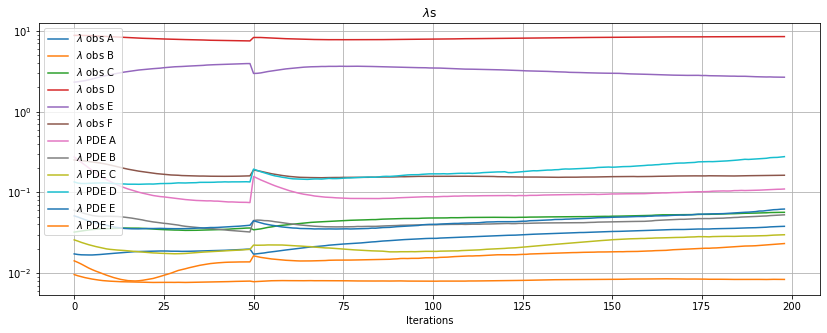

In [27]:
plot_result_multi_nodes(merge_dict_multi_nodes(results, results2, results3,  results4, results5), 
                        node_names=node_names, start=55,end=-1,  yscale='log')

In [44]:
x_domain = L * np.linspace(0, 1, x_size)
y_domain = L * np.linspace(0, 1, y_size)
N2 = x_size * y_size

T_test_index = 0#119
print(t_star[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(t_star[T_test_index], N2)  # 1 x N2

116


In [45]:
output_test = pinn(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 

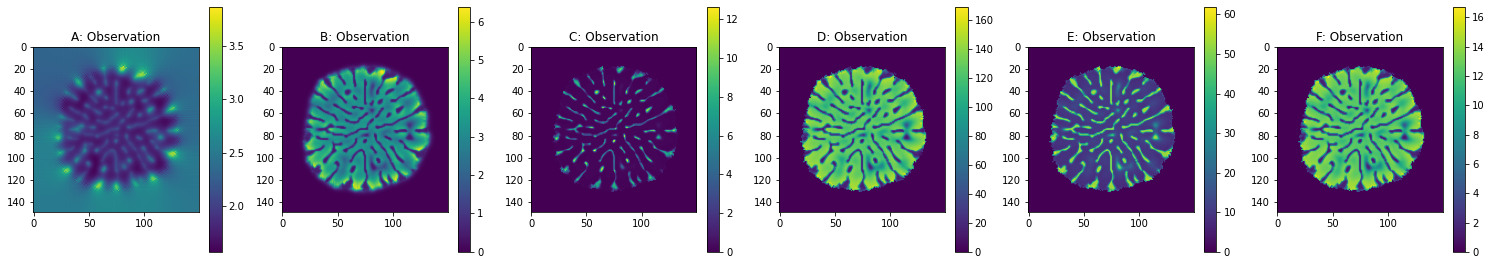

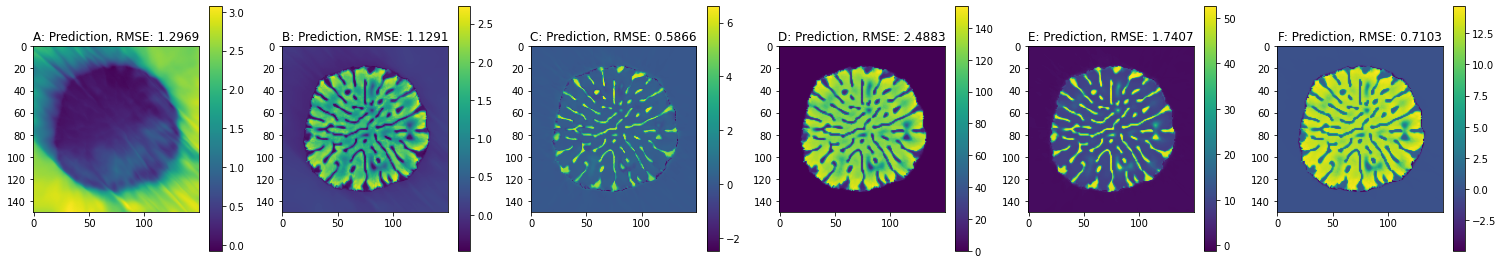

In [46]:
data_original = np.array(ds_1)
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data_original[i,:, :, t_star[T_test_index]])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    rmse = np.sqrt(np.mean((output_test[i,:, :] - data_original[i,:, :, t_star[T_test_index]])**2))
    plt.title(f"{name}: Prediction, RMSE: {rmse:.4f}")
    
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

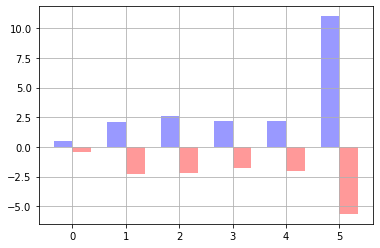

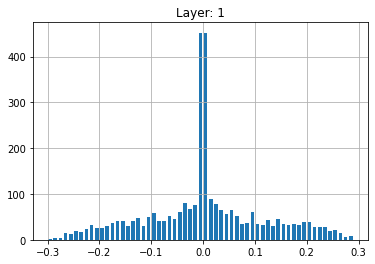

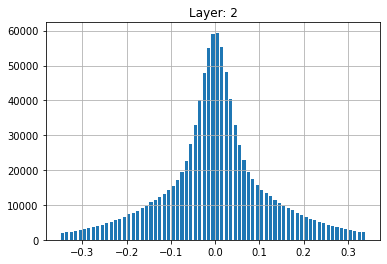

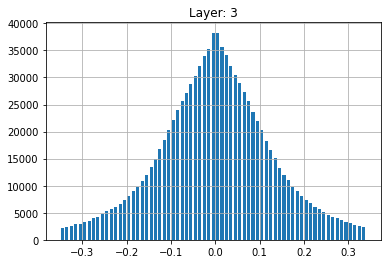

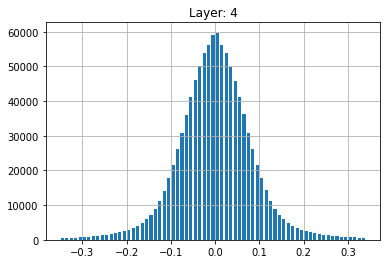

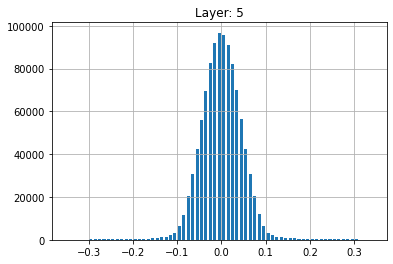

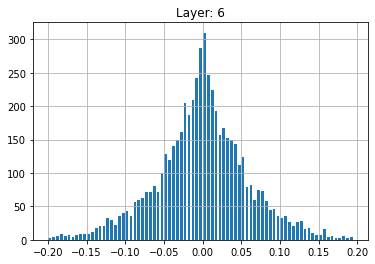

In [47]:
max_ws = np.zeros(len(pinn.Ws))
min_ws = np.zeros(len(pinn.Ws))
for i in range(len(pinn.Ws)):
    max_ws[i] = np.max(pinn.Ws[i].numpy())
    min_ws[i] = np.min(pinn.Ws[i].numpy())
    
index = np.arange(len(pinn.Ws))
bar_width = .35
plt.bar(index , max_ws, bar_width, color='b', alpha = .4)
plt.bar(index + bar_width, min_ws, bar_width, color='r', alpha = .4)

plt.xticks(index + bar_width/2, index)
plt.grid()
plt.show()

#bins = np.zeros((len(pinn.Ws), 50))
#hists = np.zeros((len(pinn.Ws), 49))
for i in range(len(pinn.Ws)):    
    if i == 0:
        bins = np.arange(-.3,.3,.01)
    elif i >= 1 and i <=4:
        bins = np.arange(-.35,0.35,.01)
    else:
        bins = np.arange(-.2,0.2,.005)
    #max_ws = np.max(pinn.Ws[i].numpy())
    #min_ws = np.min(pinn.Ws[i].numpy())
    #bins = np.arange(min_ws*.8, max_ws*.8, .8*(max_ws - min_ws)/20)
    hists, bins = np.histogram(pinn.Ws[i].numpy(), bins=bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hists, align='center', width=width)
    plt.grid()
    plt.title(f"Layer: {i+1}")
    plt.show()


In [48]:
test_d = np.vstack([XX_test, YY_test, TT_test]).T

In [49]:
test_outputs = np.zeros((test_d.shape[0], len(node_names)))
test_pdes = np.zeros((test_d.shape[0], len(node_names)))

for i, _ in enumerate(test_d):
    outs, pde_outs = pde_loss.loss_multi_nodes(pinn, test_d[i:(i+1), ...])
    test_outputs[i] = outs.numpy()
    test_pdes[i] = [item.numpy() for item in pde_outs]

In [50]:
test_outputs = np.array([ test_outputs[:, i].reshape((x_size, y_size)) for i in range(test_outputs.shape[1])]) 
test_pdes = np.array([ test_pdes[:, i].reshape((x_size, y_size)) for i in range(test_pdes.shape[1])]) 

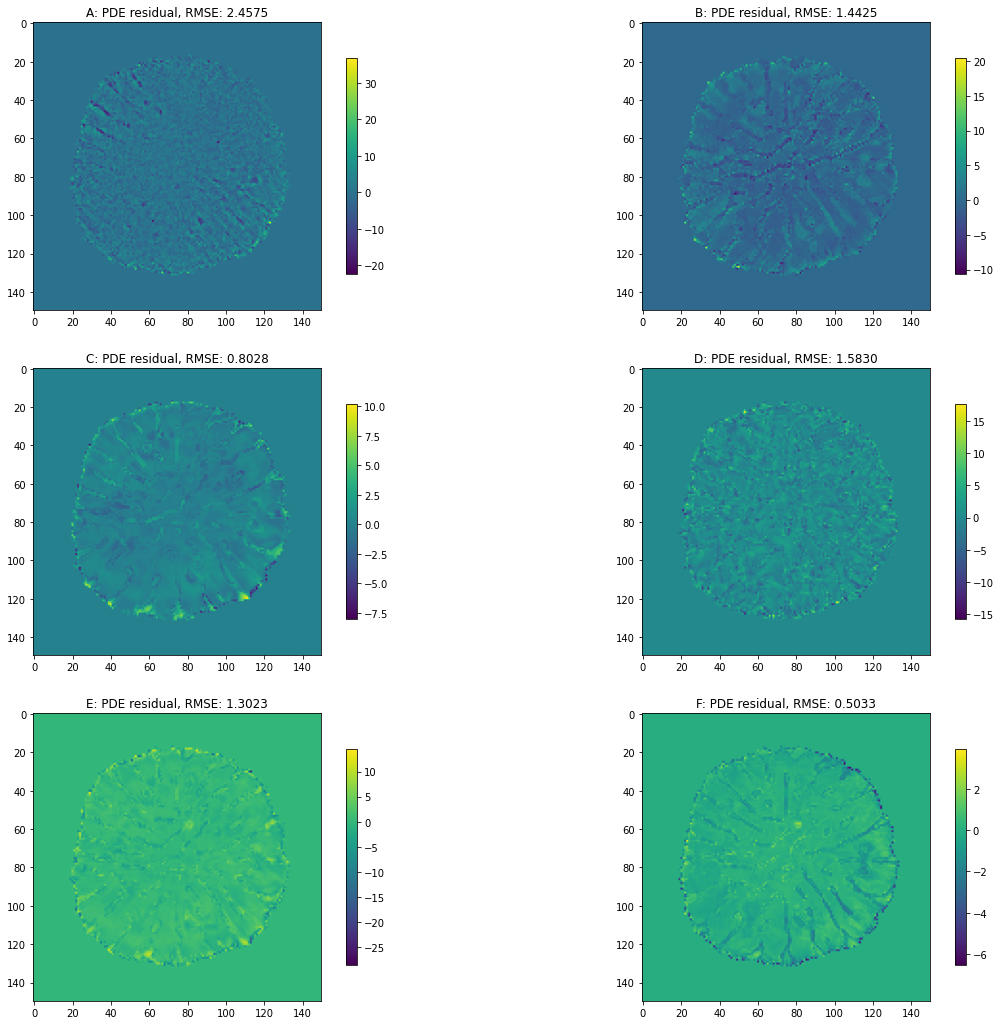

In [51]:
_ = plt.figure(figsize=(20,18))
for i, name in enumerate(node_names):
    plt.subplot(3, 2, i+1)
    d = test_pdes[i,:, :].copy()
    d[mask[:,:,t_star[T_test_index]] == 0] = 0
    rmse = np.sqrt(np.mean(d**2))
    plt.title(f"{name}: PDE residual, RMSE: {rmse:.4f}")
    
    plt.imshow(d)
    plt.colorbar(shrink=.75)

plt.show()

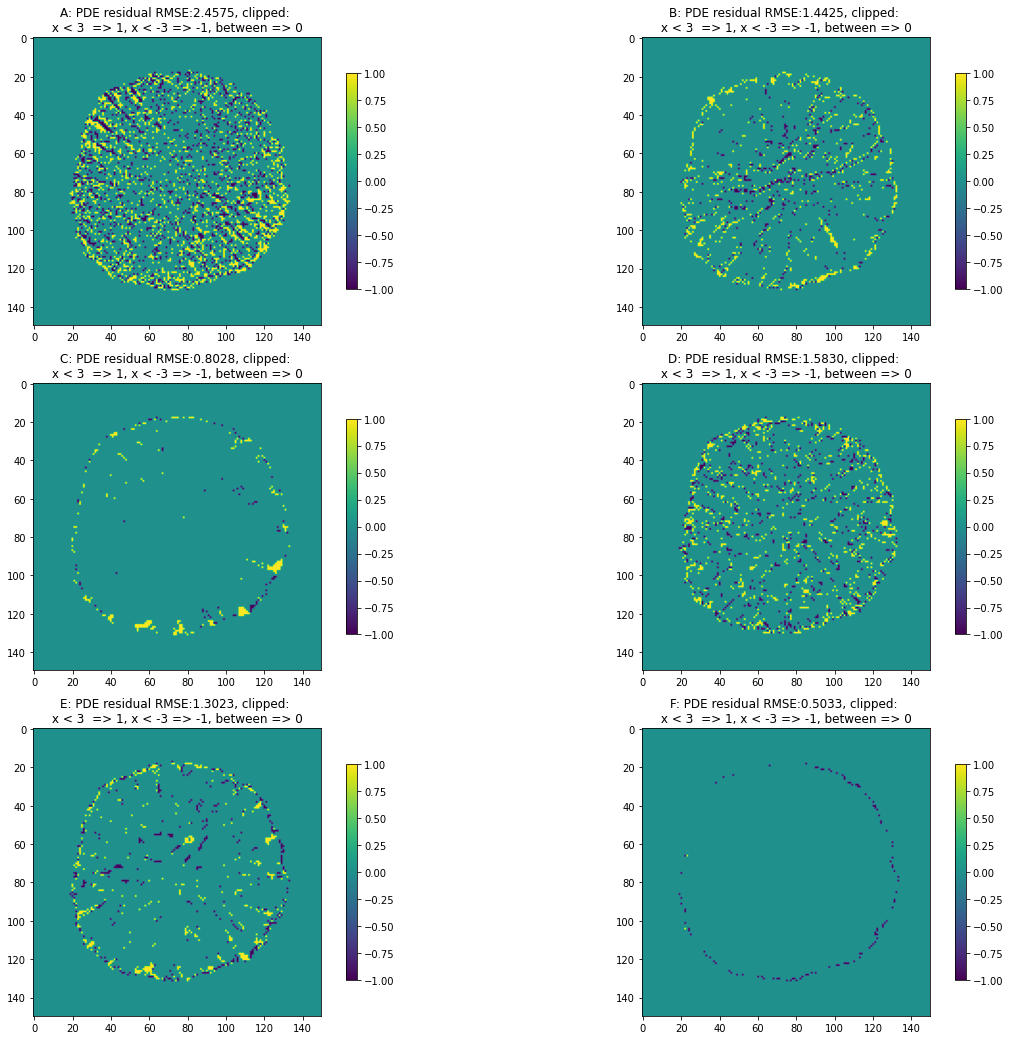

In [52]:
_ = plt.figure(figsize=(20,18))
max_L = 3
min_L = -3
for i, name in enumerate(node_names):
    plt.subplot(3, 2, i+1)
    d = test_pdes[i,:, :].copy()
    d[mask[:,:,t_star[T_test_index]] == 0] = 0
    rmse = np.sqrt(np.mean(d**2))
    plt.title(f"{name}: PDE residual RMSE:{rmse:.4f}, clipped: \n x < {max_L}  => 1, x < {min_L} => -1, between => 0 ")    
    d[(d >= min_L) & (d <= max_L)] = 0
    d[d > max_L] = 1
    d[d < min_L] = -1
    #d[d > 0] = 0
    plt.imshow(d)
    plt.colorbar(shrink=.75)

plt.show()